In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import time
import progressbar
import warnings
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV as LogReg
from scipy import signal
               
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from WOE_Houston import *


In [2]:
fy_10 = pd.read_csv('2010_clfpred')
fy_11 = pd.read_csv('2011_clfpred')
fy_12 = pd.read_csv('2012_clfpred')
fy_13 = pd.read_csv('2013_clfpred')
fy_14 = pd.read_csv('2014_clfpred')
fy_15 = pd.read_csv('2015_clfpred')
fy_16 = pd.read_csv('2016_clfpred')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()

essentials = ['Unnamed: 0',
 'Fund Id',
 'Business Area',
 'Fund Center Id',
 'GL Account',
 'GL Description',
 'GL Category',
 'GL Category Description',
 'Revenue or Expenditure',
 'Fiscal Year',
 'Fund Name',
 'Fund Type Descr',
 'Business Area Name',
 'Fund Center Name',
 'Commitment Set Description',
 'Original Budget',
 'Current Budget',
 'Actuals',
 '3Y_Past_Actuals',
 '2Y_Past_Actuals',
 '1Y_Past_Actuals',
 '2Y_1Y_Actuals_Mean',
 '3Y_2Y_1Y_Actuals_Mean',
 '3Y_Past_Original_Budget',
 '2Y_Past_Original_Budget',
 '1Y_Past_Original_Budget',
 '2Y_1Y_Original_Budget_Mean',
 '3Y_2Y_1Y_Original_Budget_Mean',
 '3Y_Past_OA_Difference',
 '2Y_Past_OA_Difference',
 '1Y_Past_OA_Difference',
 '2Y_1Y_OA_Difference_Mean',
 '3Y_2Y_1Y_OA_Difference_Mean',
 'OA_Difference',
 'Yearly Crime Index',
 'Yearly Avg High Temp',
 'Yearly Avg Low Temp',
 'Yearly Rain Fall',
 'Astros Playoff Rounds',
 'Astros Yearly Attendance',
 'Rockets Playoff Rounds',
 'Texans Playoff Rounds',
 'Texans Average Attendance',
 'Rockets Total Attendance']

dummies = ['Fund Name_Asset Forfeiture Fund - Justice',
 'Fund Name_Asset Forfeiture Fund - State',
 'Fund Name_Auto Dealers Fund',
 'Fund Name_Building Inspection Fund',
 'Fund Name_C&E-Civic Center Facility Revenue Fund',
 'Fund Name_Cable Television Fund',
 'Fund Name_Child Safety Fund',
 'Fund Name_Digital Houston Special Revenue',
 'Fund Name_Expansion of Recycling Program',
 'Fund Name_Fleet Management Fund',
 'Fund Name_GSD - In-House Renovation Revolving Fund',
 'Fund Name_General Fund',
 'Fund Name_Greater Houston Trans & Emer Center',
 'Fund Name_HAS-Revenue Fund',
 'Fund Name_Health Benefits Fund',
 'Fund Name_Historic Preservation Fund',
 'Fund Name_Houston Emergeny Center',
 'Fund Name_Long-Term Disablility Plan Fund',
 'Fund Name_Municipal Court Technology Fund',
 'Fund Name_PWE-Combined Utility System Gen Pur Fund',
 'Fund Name_PWE-Combined Utility System Oper Fund',
 'Fund Name_PWE-W & S System Operating Fund',
 'Fund Name_Park Special Revenue Fund',
 'Fund Name_Parking Mangement Operating Fund',
 'Fund Name_Police Special Services',
 'Fund Name_Project Cost Recovery',
 'Fund Name_Property & Casualty Fund',
 'Fund Name_Stormwater Fund',
 'Fund Name_Supplemental Environmental Proj',
 'Fund Name_Workers Compensation Admin Fund',
 'Fund Type Descr_Enterprise Funds',
 'Fund Type Descr_General Funds',
 'Fund Type Descr_Internal Services Funds',
 'Fund Type Descr_Special Revenue Funds',
 'Business Area Name_Admn. & Regulatory Affairs',
 'Business Area Name_Business Opportunity',
 "Business Area Name_City Controller's Office",
 'Business Area Name_City Council',
 'Business Area Name_City Secretary',
 'Business Area Name_Citywide General Government',
 'Business Area Name_Convention and Entertainment',
 'Business Area Name_Finance',
 'Business Area Name_General Debt Services',
 'Business Area Name_General Services Department',
 'Business Area Name_Health & Human Services',
 'Business Area Name_Housing and Community Devp.',
 'Business Area Name_Houston Airport System (HAS)',
 'Business Area Name_Houston Emergency Center (HEC)',
 'Business Area Name_Houston Fire Department (HFD)',
 'Business Area Name_Houston Police Department',
 'Business Area Name_Human Resources Dept.',
 'Business Area Name_Information Technology (IT)',
 'Business Area Name_Legal Department',
 'Business Area Name_Library',
 "Business Area Name_Mayor's Office",
 'Business Area Name_Municipal Court Judicial',
 'Business Area Name_Municipal Courts Department',
 'Business Area Name_Parks & Recreation',
 'Business Area Name_Planning & Development',
 'Business Area Name_Public Works & Engineering-PWE',
 'Business Area Name_Solid Waste Management',
 'Commitment Set Description_50 - Total Expenditures',
 'Business Area Name_Houston Police Department-HPD',
 'Business Area Name_Houston Information Tech Svcs'
]

drop_list = [
    
    'Fund Name', 
    'Fund Type Descr', 
    'Business Area Name',
    'Commitment Set Description',
    'GL Description',
    'GL Category Description',
    'Revenue or Expenditure',
    'Fund Type Descr',
    'Fund Center Name'
]

       
        

        

In [3]:
df = pd.concat([x for x in fy_list])
len(df)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


80493

In [4]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

In [5]:
df.dtypes

1YP_OA_Diff_Over_80K                                    int64
1Y_Past_Actuals                                       float64
1Y_Past_OA_Difference                                 float64
1Y_Past_Original_Budget                               float64
2Y_1Y_Actuals_Mean                                    float64
2Y_1Y_OA_Difference_Mean                              float64
2Y_1Y_Original_Budget_Mean                            float64
2Y_Past_Actuals                                       float64
2Y_Past_OA_Difference                                 float64
2Y_Past_Original_Budget                               float64
3Y_2Y_1Y_Actuals_Mean                                 float64
3Y_2Y_1Y_OA_Difference_Mean                           float64
3Y_2Y_1Y_Original_Budget_Mean                         float64
3Y_Past_Actuals                                       float64
3Y_Past_OA_Difference                                 float64
3Y_Past_Original_Budget                               float64
Actuals 

In [6]:
df['Actuals'].describe()

count    8.049300e+04
mean     2.836648e+05
std      5.408412e+06
min     -2.410083e+07
25%      3.232000e+02
50%      3.328030e+03
75%      3.537123e+04
max      4.216266e+08
Name: Actuals, dtype: float64

In [40]:
df.loc[df['Actuals']>=0]['Actuals'].sum()/7

3277973555.088571

In [7]:
df['Original Budget'].describe()

count    8.049300e+04
mean     2.949861e+05
std      5.798348e+06
min     -3.020500e+06
25%      6.000000e+02
50%      4.000000e+03
75%      3.702600e+04
max      4.418581e+08
Name: Original Budget, dtype: float64

In [8]:
df['Revenue or Expenditure'].describe()

count            80493
unique               1
top       Expenditures
freq             80493
Name: Revenue or Expenditure, dtype: object

In [9]:
df['OA_Difference'].describe()

count    8.049300e+04
mean    -1.132133e+04
std      6.816201e+05
min     -1.014464e+08
25%     -3.003000e+03
50%     -2.027200e+02
75%      6.085300e+02
max      2.587155e+07
Name: OA_Difference, dtype: float64

In [10]:
actuals = df.loc[df['Revenue or Expenditure']=='Expenditures']['Actuals']
OA_Differences = df['OA_Difference']
original_budget = df['Original Budget']
len(actuals)

80493

In [11]:
actuals = downsample(actuals, int(len(actuals)/16))
OA_Differences = downsample(OA_Differences, int(len(OA_Differences)/16))
original_budget = downsample(original_budget, int(len(original_budget)/16))
len(actuals)

5030

In [27]:
type(actuals)

numpy.ndarray

In [26]:
sorted(np.unique(actuals, return_counts=True), key=lambda x: x[1])

[array([-6.37144672e+06, -1.76529111e+06, -7.70578762e+04, ...,
         6.71577547e+07,  7.20162619e+07,  1.05611532e+08]),
 array([1, 1, 1, ..., 1, 1, 1])]

Text(0.5, 1.0, "Actual Spending - 10's of Millions")

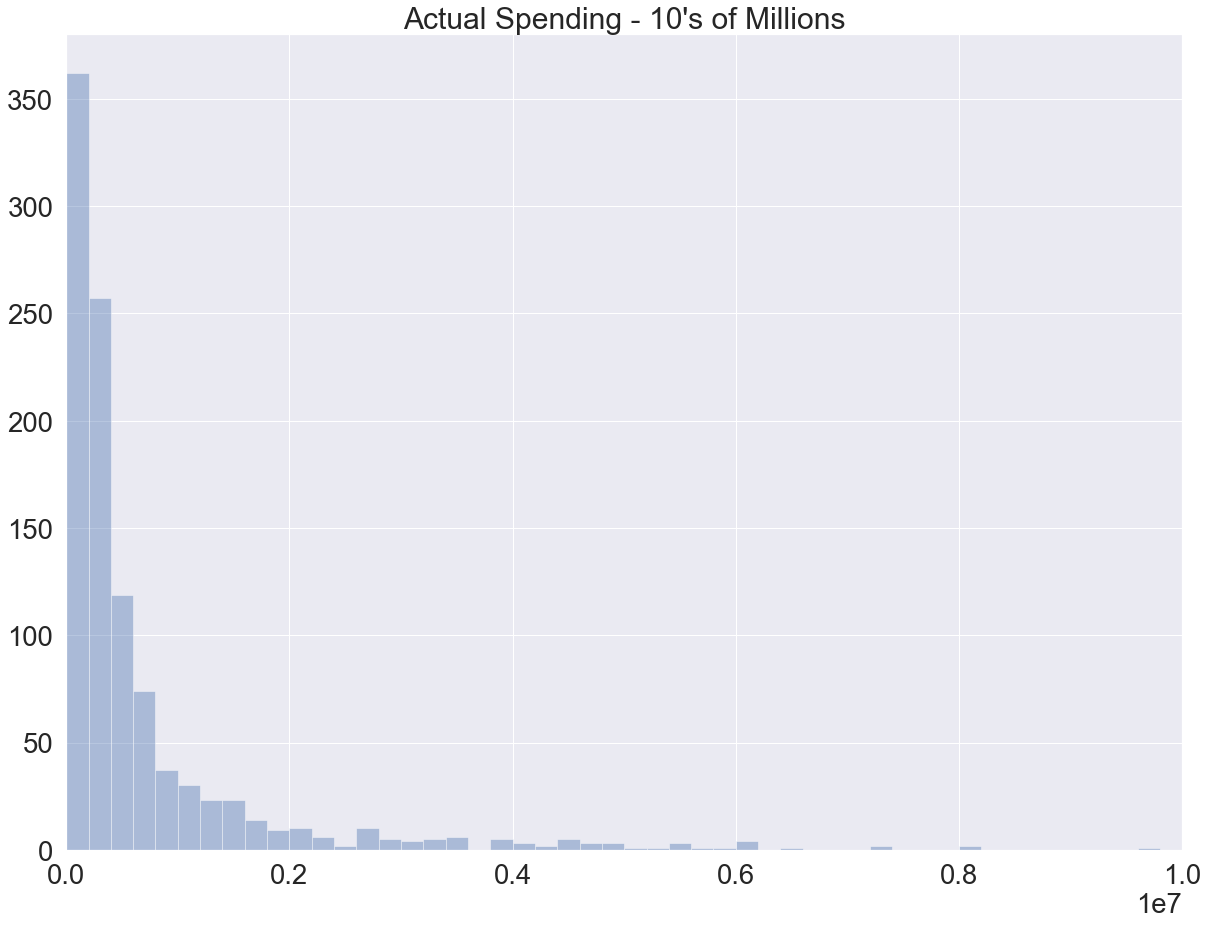

In [64]:
#Seaborn distplot
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
bins_ = np.arange(-10000000,10000000,10000000/50)

fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(list([actuals[np.abs(actuals) >  100000]]),ax=ax, bins=bins_, kde=False)#bins=10, ax=ax)
#sns.distplot(list(np.log10(actuals[actuals > 0])),ax=ax)#bins=10, ax=ax)

ax.set_xlim(0,10000000)
#ax.get_yaxis().set_visible(False)
#ax.set(xticks=[-40000000, -20000000,0, 20000000, 40000000])
ax.set_title("Actual Spending - 10's of Millions")

Text(0.5, 1.0, "Original Budget - 10's of Millions")

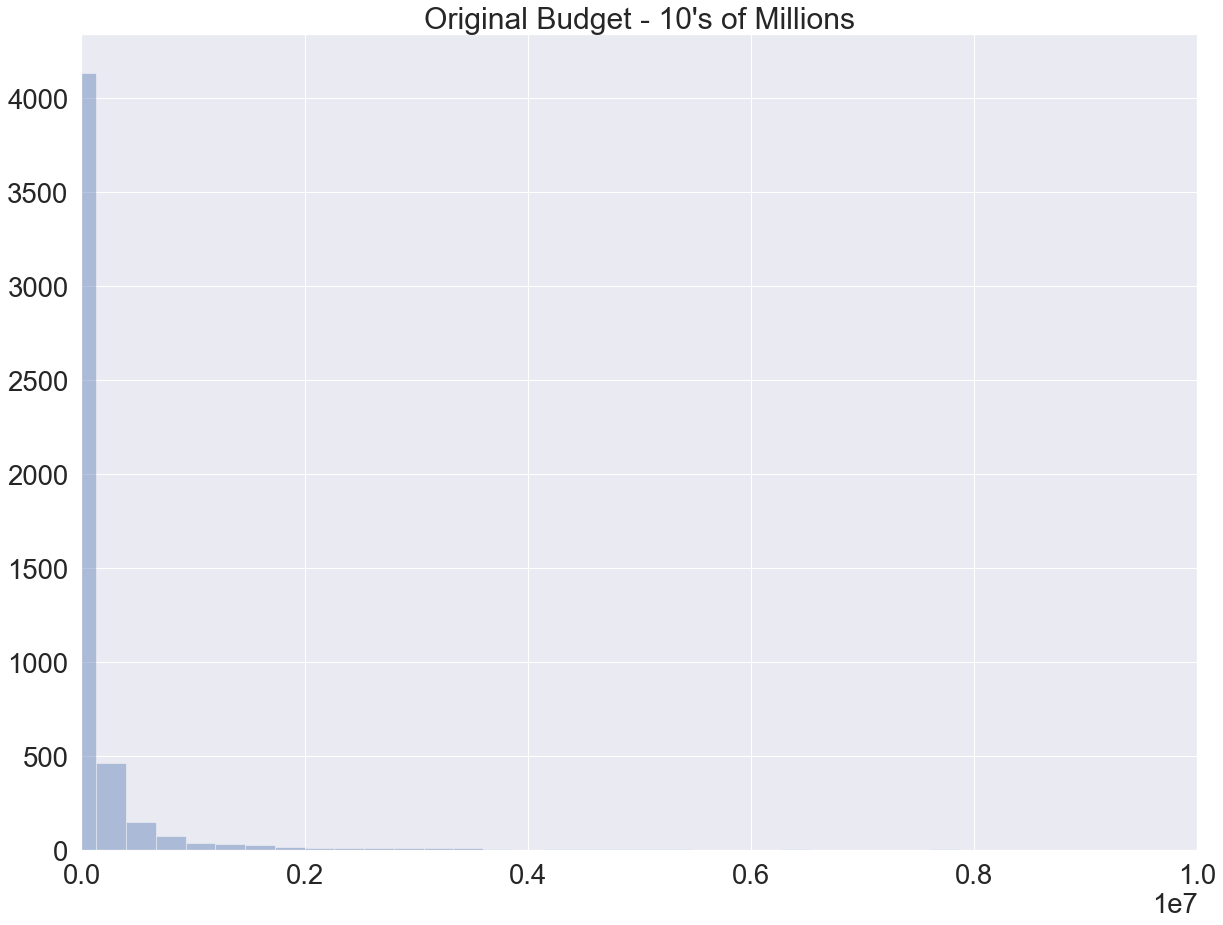

In [63]:
#Seaborn distplot
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
left = -10000000
right= 10000000
bins_ = np.arange(left,right,(right-left)/75)

fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(list(original_budget),bins=bins_, ax=ax, kde=False)

ax.set_xlim(0,10000000)
#ax.get_yaxis().set_visible(False)
#ax.set(xticks=[-40000000, -20000000,0, 20000000, 40000000])
ax.set_title("Original Budget - 10's of Millions")

Text(0.5, 1.0, 'Budget Residuals on Actual Spending')

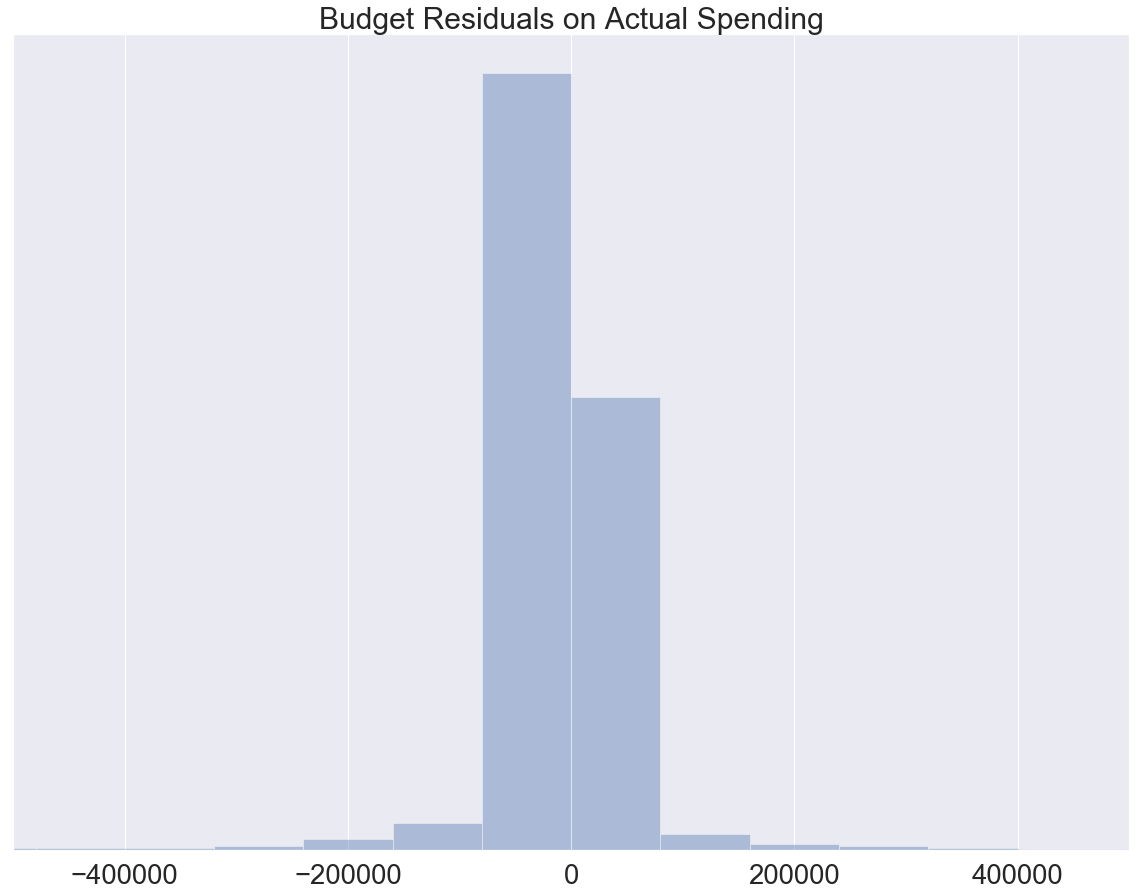

In [50]:
#Seaborn distplot
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
left = -2000000
right= 2000000
bins_ = np.arange(left,right,(right-left)/50)

fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(list(OA_Differences),bins=bins_, ax=ax, kde=False)

ax.set_xlim(-500000,500000)
ax.get_yaxis().set_visible(False)
#ax.set(xticks=[-40000000, -20000000,0, 20000000, 40000000])
ax.set_title("Budget Residuals on Actual Spending")

In [58]:
values = df.groupby('GL Description').sum()['Actuals'].sort_values(ascending=False)[:30].values
labels = df.groupby('GL Description').sum()['Actuals'].sort_values(ascending=False)[:30].index

In [59]:
labels

Index(['500020 - Salary Base Pay - Classified',
       '500010 - Salary Base Pay - Civilian',
       '532080 - System Debt Service Transfers',
       '532100 - Transfer to Combined Utility System Oper',
       '532050 - Transfers to Public Improvement Bonds De',
       '503020 - Health Insurance - Active Classified',
       '501090 - Pension - Police', '501070 - Pension - Civilian',
       '521505 - Electricity', '501080 - Pension - Fire',
       '503010 - Health Insurance - Active Civilian',
       '500070 - Overtime - Classified',
       '520144 - Limited Purpose Annexation Payment',
       '503050 - Health Insurance - Retiree Civilian',
       '532095 - Transfer to Stormwater Fund', '502010 - FICA - Civilian',
       '500160 - Training Incentive Pay - Classified',
       '521405 - Building Maintenance Services', '511110 - Fuel',
       '520130 - River Authority Contracts',
       '522605 - Active Employee Incurred Claims', '520118 - Refuse Disposal',
       '522740 - Interfund Polic

Text(0.5, 1.0, 'Top Spending Categories')

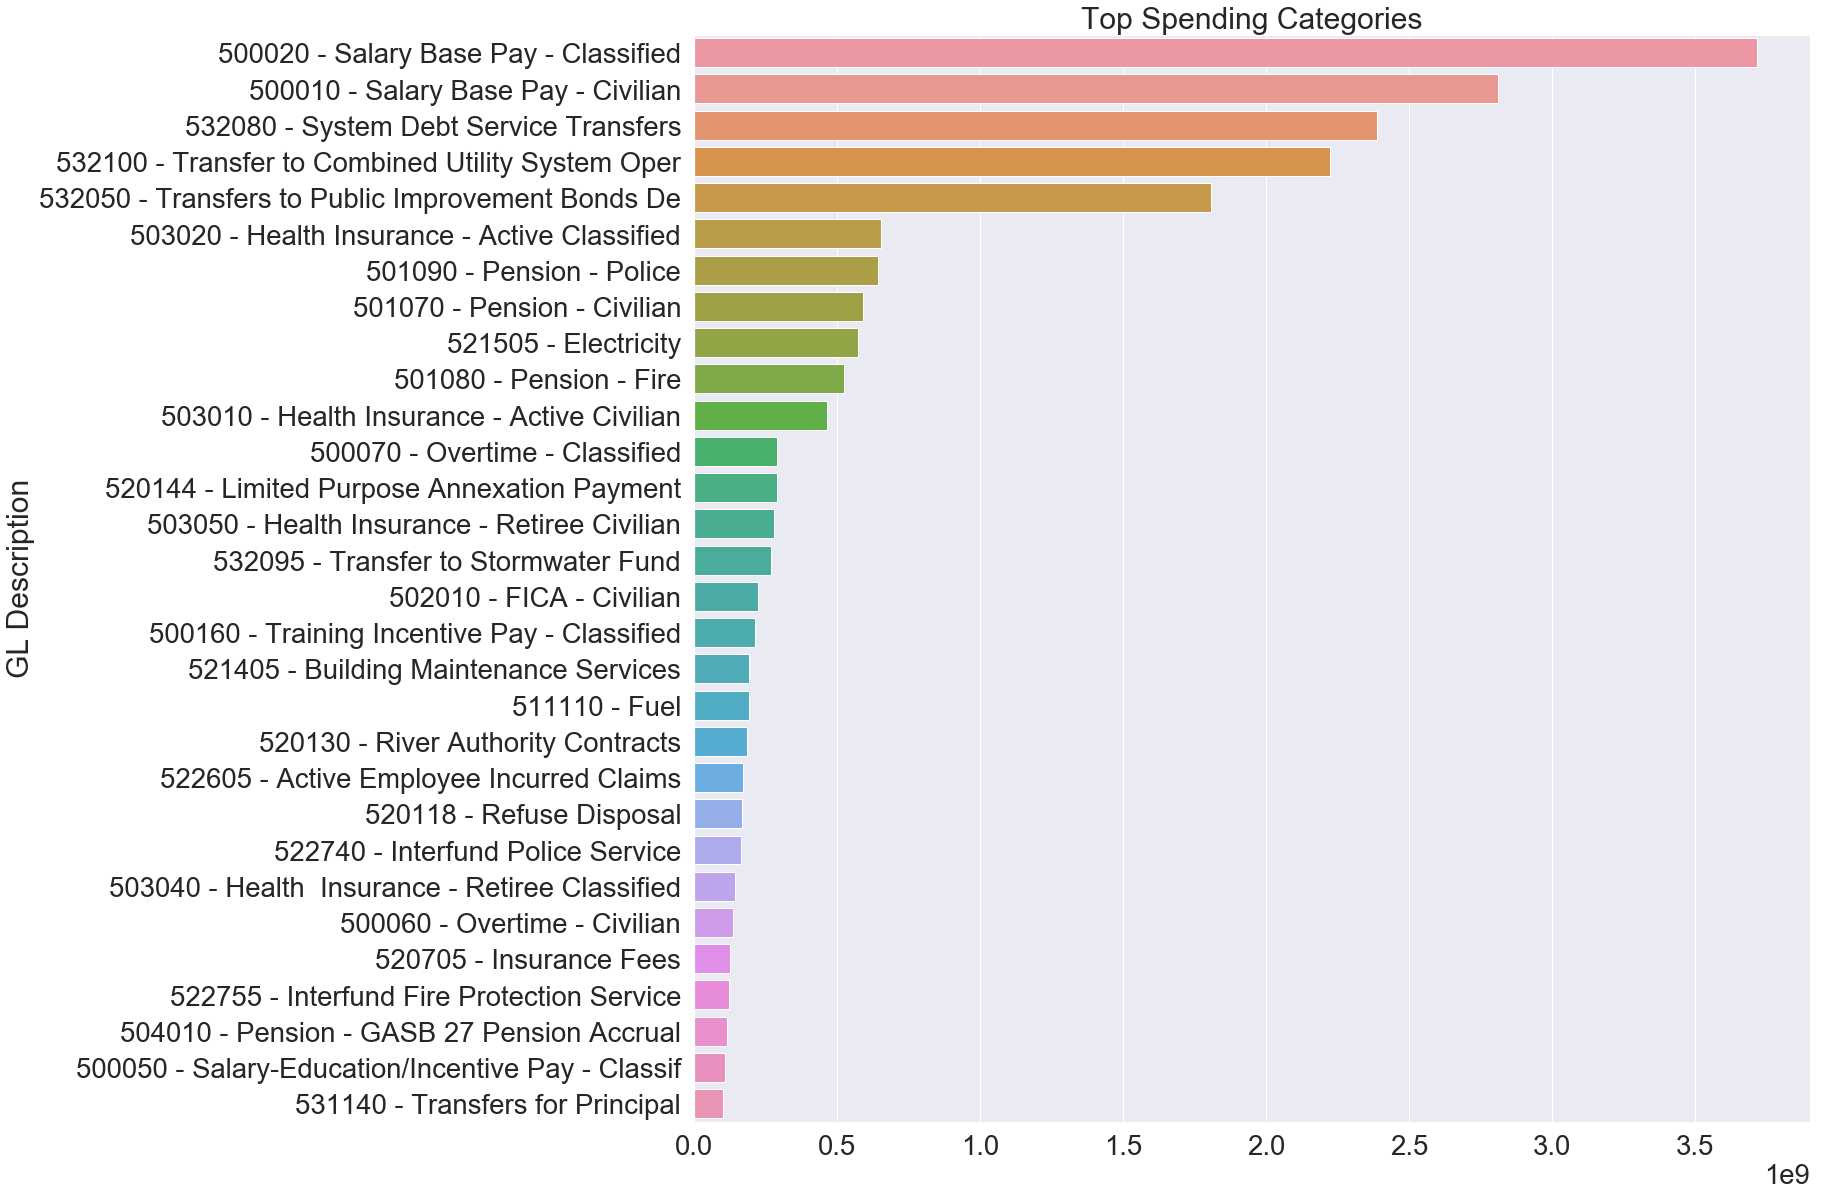

In [61]:
fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(y=labels, x=values, orient='h', ax=ax)
ax.set_title("Top Spending Categories")

In [62]:
df['Actuals'].sum()/7

3261861492.3114285

In [41]:
for y in fy_list:
    print(y['Actuals'].sum())

3034894080.38
3114629563.7200003
3045204499.27
3174583267.5299997
3378776290.02
3472756494.4700003
3612186250.79
